In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftfreq, fftshift
import pandas as pd
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE

In [8]:
rerun = True
filename_end = "relations_ref"

In [ ]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [4]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

In [9]:
sample_sigmas = np.arange(0.01, 5.0, 0.01)

n_avgs = 1000

gen_fft_sigmas = np.zeros((n_avgs, sample_sigmas.size))

In [ ]:
if(rerun == True):

    file = open("sigma_" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.2f}' for x in sample_sigmas) + "\n")

    for j in range(n_avgs):
        for i in range(sample_sigmas.size):
            corrup = pymri.corrupted_snr(sig, 0.0, sample_sigmas[i])

            freqs, sig_fft = pymri.fourier_spectrum(corrup, dt, B0)
            P_fft = np.nanmax(sig_fft)
            sig_fft = sig_fft/P_fft # Normalization addition to work with highest peak = 1.0

            gen_fft_sigmas[j, i] += 1.0/pymri.snr(sig_fft) 

        file.write(",".join(str(x) for x in gen_fft_sigmas[j,:]) + "\n")

    file.close()

In [ ]:
# In case the simulation had lost its parameters
if(rerun==False):
    sig_rel = pd.read_csv("sigma_" + filename_end + ".csv")

    sample_sigmas = sig_rel.keys().to_numpy(dtype=np.float64)
    gen_fft_sigmas = sig_rel.values

In [11]:
snrs = 1.0/gen_fft_sigmas

avg_gen_fft_sigmas = np.average(gen_fft_sigmas, axis = 0)
std_gen_fft_sigmas = np.std(gen_fft_sigmas, axis = 0)

avg_snrs = np.average(snrs, axis = 0)
std_snrs = np.std(snrs, axis = 0)

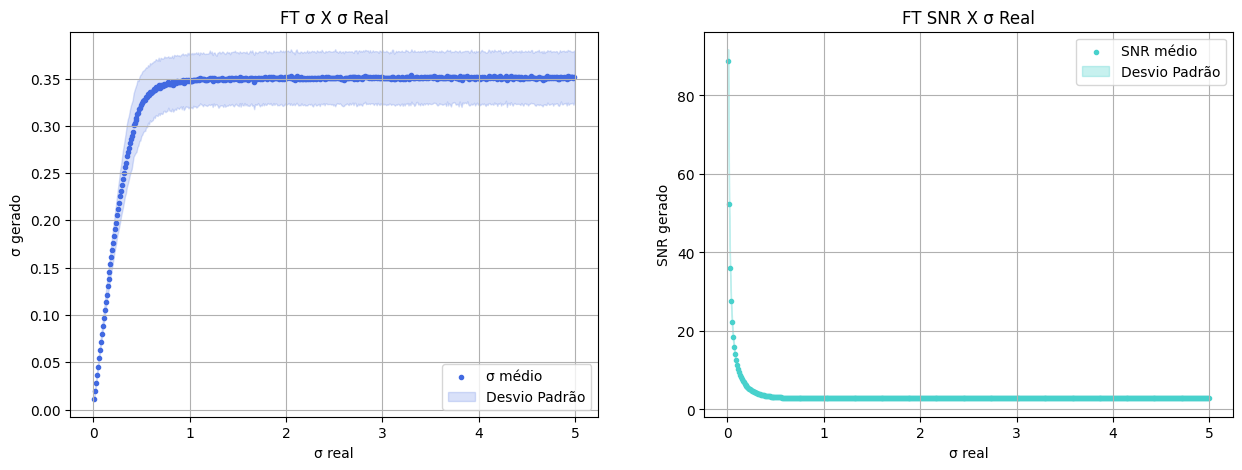

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(sample_sigmas, avg_gen_fft_sigmas, c = "royalblue", marker= ".", label = "σ médio")
plt.fill_between(sample_sigmas, avg_gen_fft_sigmas - std_gen_fft_sigmas, avg_gen_fft_sigmas + std_gen_fft_sigmas, alpha = 0.2, color = "royalblue", label = "Desvio Padrão")
plt.title("FT σ X σ Real")
plt.xlabel("σ real")
plt.ylabel("σ gerado")
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.scatter(sample_sigmas, avg_snrs, c = "mediumturquoise", marker= ".", label = "SNR médio")
plt.fill_between(sample_sigmas, avg_snrs - std_snrs, avg_snrs + std_snrs, alpha = 0.3, color = "mediumturquoise", label = "Desvio Padrão")
plt.title("FT SNR X σ Real")
plt.xlabel("σ real")
plt.ylabel("SNR gerado")
plt.legend()
plt.grid(True)

## Modelling the curve

In [13]:
from scipy.optimize import curve_fit

In [ ]:
def model_function(x, a, c):
    b = np.log(a)
    return a - np.exp(b - c*x)

In [36]:
n_div = 10
size_div = int(gen_fft_sigmas.shape[0]/n_div)

a_fft_s, c_fft_s = np.zeros(n_div),  np.zeros(n_div)

In [40]:
for i in range(n_div):
    curve_fft = curve_fit(model_function, sample_sigmas, np.average(gen_fft_sigmas[size_div*i: size_div*(i + 1), :], axis=0))
    a_fft_s[i], c_fft_s[i] = curve_fft[0]

In [41]:
a = np.average(a_fft_s), np.std(a_fft_s)
c = np.average(c_fft_s), np.std(c_fft_s)

print(a[0], a[1])
print(c[0], c[1])

0.3520674111074248 0.0001342147921187426
3.92105593497381 0.0119465523196671


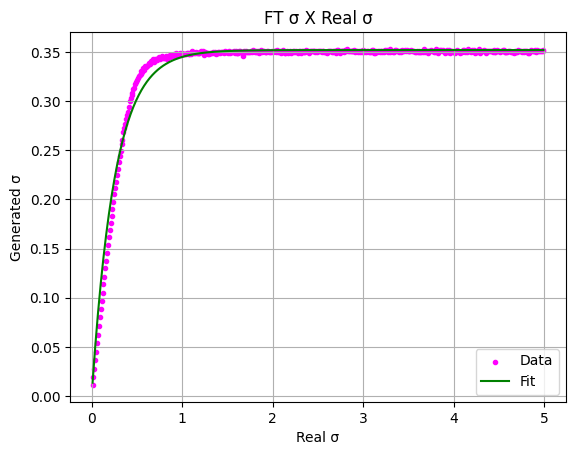

In [43]:
plt.scatter(sample_sigmas, avg_gen_fft_sigmas, c = "magenta", marker= ".", label = "Data")
plt.plot(sample_sigmas, model_function(sample_sigmas, a[0], c[0]), c = "green", label = "Fit")
plt.title("FT σ X Real σ")
plt.xlabel("Real σ")
plt.ylabel("Generated σ")
plt.grid(True)
plt.legend()

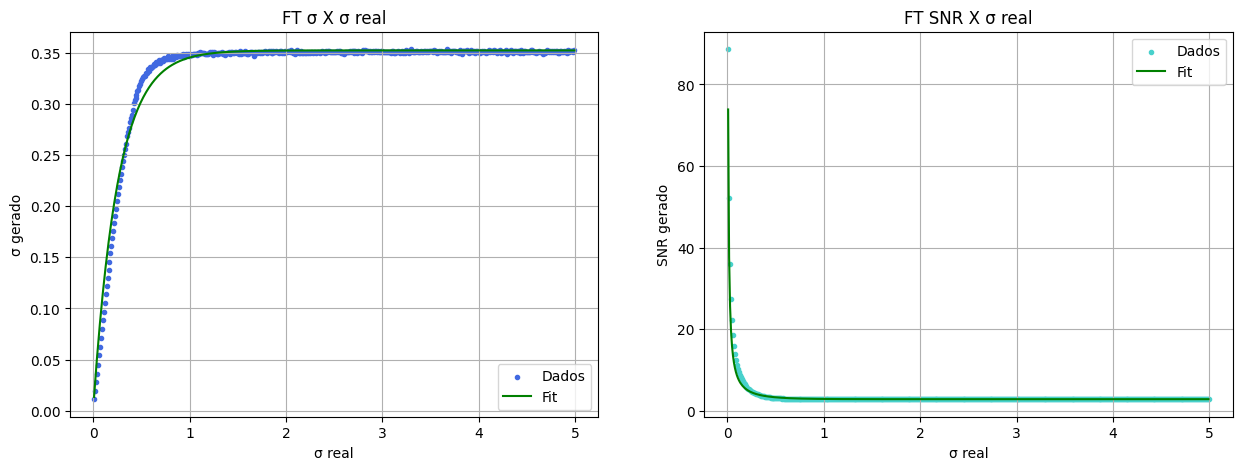

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(sample_sigmas, avg_gen_fft_sigmas, c = "royalblue", marker= ".", label = "Dados")
plt.plot(sample_sigmas, model_function(sample_sigmas, a[0], c[0]), c = "green", label = "Fit")
plt.title("FT σ X σ real")
plt.xlabel("σ real")
plt.ylabel("σ gerado")
plt.grid(True)
plt.legend()


plt.subplot(122)
plt.scatter(sample_sigmas, 1.0/avg_gen_fft_sigmas, c = "mediumturquoise", marker= ".", label = "Dados")
plt.plot(sample_sigmas, 1.0/model_function(sample_sigmas, a[0], c[0]), c = "green", label = "Fit")
plt.title("FT SNR X σ real")
plt.xlabel("σ real")
plt.ylabel("SNR gerado")
plt.grid(True)
plt.legend()

In [46]:
def snr_to_sigma(snr : float, a : float, b : float, c : float):
    given_sigma = 1.0/snr
    return (b - np.log(a - given_sigma))/c

In [47]:
target_snrs = np.arange(5.0, 1000.0, 5.0)
resulting_snrs = np.zeros((n_avgs, target_snrs.size))
RMSE_vals = np.zeros_like(target_snrs)
avg_snrs = np.zeros_like(target_snrs)
std_snrs = np.zeros_like(target_snrs)

In [48]:
sigmas = snr_to_sigma(target_snrs, a[0], b[0], c[0])

In [49]:
if(rerun == True):

    file = open("middle_snr_" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.6f}' for x in sigmas) + "\n")

    for j in range(n_avgs):
        for i in range(sigmas.size):
            corrup = pymri.corrupted_snr(sig, 0.0, sigmas[i])

            freqs, sig_fft = pymri.fourier_spectrum(corrup, dt, B0)

            sig_fft = sig_fft/np.nanmax(sig_fft) # Normalization addition to work with highest peak = 1.0

            resulting_snrs[j, i] = pymri.snr(sig_fft)

        file.write(",".join(str(x) for x in resulting_snrs[j,:]) + "\n")

    file.close()


In [50]:
# If simulation is lost
if(rerun == False):
    sig_rel = pd.read_csv("middle_snr_" + filename_end + ".csv")

    sigmas = sig_rel.keys().to_numpy(dtype=np.float64)
    resulting_snrs = sig_rel.values


In [51]:
for i in range(target_snrs.size):
    RMSE_vals[i] = RMSE(np.tile(target_snrs[i], n_avgs), resulting_snrs[:, i])
    avg_snrs[i] = np.average(resulting_snrs[:, i])

avg_snrs_error = np.std(resulting_snrs, axis = 0)

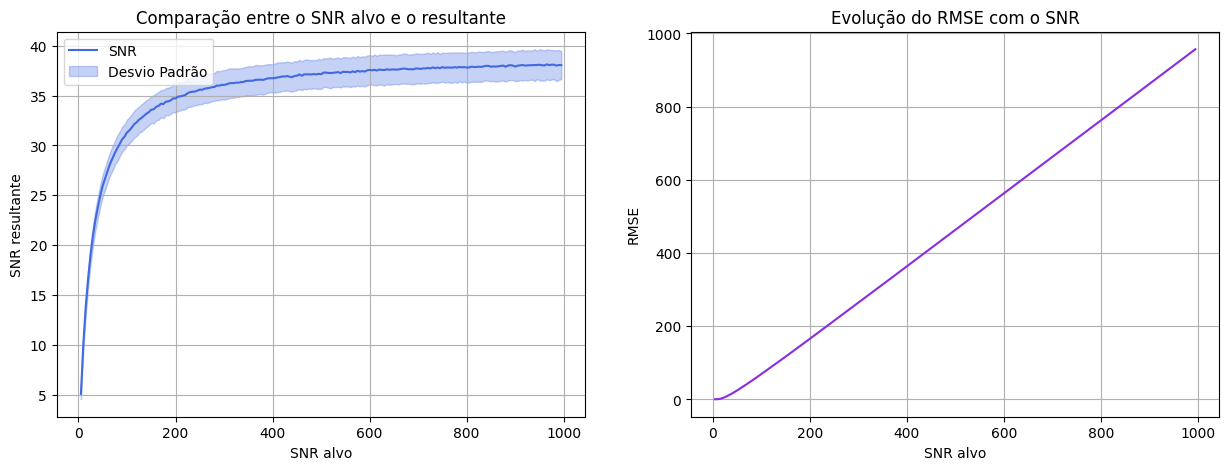

In [52]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(target_snrs, avg_snrs, c = "royalblue", label = "SNR")
plt.fill_between(target_snrs, avg_snrs - avg_snrs_error, avg_snrs + avg_snrs_error, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.title("Comparação entre o SNR alvo e o resultante")
plt.xlabel("SNR alvo")
plt.ylabel("SNR resultante")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(target_snrs, RMSE_vals, c = "blueviolet")
plt.title("Evolução do RMSE com o SNR")
plt.xlabel("SNR alvo")
plt.ylabel("RMSE")
plt.grid()

In [113]:
n_div = 10

size_div = int(resulting_snrs.shape[0]/n_div)

d_fft_s, e_fft_s, f_fft_s = np.zeros(n_div), np.zeros(n_div), np.zeros(n_div)

In [114]:
def model_function_2(x, a, b, c):
    return a - np.exp(b - c*x)

def model_function_3(x, a, b):
    return a*np.log(x) + b
# np.exp((y - b)/a) = x

In [115]:
for i in range(n_div):
    curve_fft = curve_fit(model_function_2, target_snrs, np.average(resulting_snrs[size_div*i: size_div*(i + 1), :], axis=0))
    # curve_fft = curve_fit(model_function_3, target_snrs, np.average(resulting_snrs[size_div*i: size_div*(i + 1), :], axis=0))
    d_fft_s[i], e_fft_s[i], f_fft_s[i] = curve_fft[0]
    # d_fft_s[i], e_fft_s[i] = curve_fft[0]

C:\Users\Lampada\AppData\Local\Temp\ipykernel_29736\3291851174.py:2: RuntimeWarning: overflow encountered in exp
  return a - np.exp(b - c*x)


In [116]:
print(d_fft_s)
print(e_fft_s)
print(f_fft_s)

[37.27433077 37.27940502 37.28391651 37.29197953 37.28455002 37.27075822
 37.27293253 37.2963749  37.27418237 37.27997051]
[3.3654907  3.37162216 3.370057   3.37019967 3.36921611 3.3708609
 3.3701493  3.36638371 3.36694177 3.3662837 ]
[0.01570127 0.01582221 0.01578311 0.01573029 0.01575381 0.01584214
 0.0158401  0.0156811  0.01576189 0.01560299]


In [117]:
d = np.average(d_fft_s), np.std(d_fft_s)
e = np.average(e_fft_s), np.std(e_fft_s)
f = np.average(f_fft_s), np.std(f_fft_s)

print(d[0], d[1])
print(e[0], e[1])
print(f[0], f[1])

37.28084003805943 0.008014557524558234
3.36872050204163 0.002103717148175889
0.01575189007616532 7.222116346465667e-05


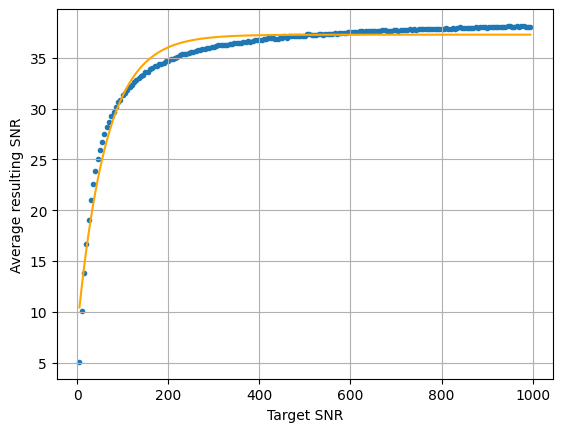

In [122]:
plt.scatter(target_snrs, avg_snrs, marker = ".")
plt.plot(target_snrs, model_function_2(target_snrs, d[0], e[0], f[0]), c = "orange")
plt.xlabel("Target SNR")
plt.ylabel("Average resulting SNR")
plt.grid(True)

In [123]:
def snr_to_sigma(snr : float, a : float, c : float, d : float, e : float, f : float):
    """Returns a sigma value that will approximately corresponds to a given SNR value.
    
    Parameters
    ----------
    
    snr : float
        Desired SNR value.
    expected_peak : float
        The signal's expected peak."""

    # actual_snr = (np.log(snr) - b_exp)/a_exp
    # actual_snr = (snr - e)/d # Linear correction (inverse of the linear function)
    actual_snr = (e - np.log(d - snr))/f
    # actual_snr = np.exp((snr - e)/d)
    given_sigma = 1.0/actual_snr

    b = np.log(a)
    return (b - np.log(a - given_sigma))/c # inverse of the model function

In [124]:
resulting_snrs_correct = np.zeros((n_avgs, target_snrs.size))
RMSE_vals_correct = np.zeros_like(target_snrs)
avg_snrs_correct = np.zeros_like(target_snrs)

In [125]:
sigma = snr_to_sigma(300.0, a[0], c[0], d[0], e[0], f[0])

sigmas = snr_to_sigma(target_snrs, a[0], c[0], d[0], e[0], f[0])
# print(target_snrs)

# print(sigmas)

C:\Users\Lampada\AppData\Local\Temp\ipykernel_29736\3551365771.py:14: RuntimeWarning: invalid value encountered in log
  actual_snr = (e - np.log(d - snr))/f
